
## Config


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 27.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB

In [ ]:

EMBEDDING_DIM = 300

MAX_SEQUENCE_LENGTH = 10
VALIDATION_SPLIT = 0.1


RATE_DROP_LSTM = 0.17
RATE_DROP_DENSE = 0.25
NUMBER_LSTM = 50
NUMBER_DENSE_UNITS = 50
ACTIVATION_FUNCTION = 'relu'


siamese_config = {
	'EMBEDDING_DIM': EMBEDDING_DIM,
	'MAX_SEQUENCE_LENGTH' : MAX_SEQUENCE_LENGTH,
	'VALIDATION_SPLIT': VALIDATION_SPLIT,
	'RATE_DROP_LSTM': RATE_DROP_LSTM,
	'RATE_DROP_DENSE': RATE_DROP_DENSE,
	'NUMBER_LSTM': NUMBER_LSTM,
	'NUMBER_DENSE_UNITS': NUMBER_DENSE_UNITS,
	'ACTIVATION_FUNCTION': ACTIVATION_FUNCTION
}

## Inputhandler

In [ ]:
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from gensim.models import FastText
from sklearn.model_selection import train_test_split, StratifiedKFold
from flair.data import Sentence
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
import numpy as np
import gc

def flair_embed_meta_data(documents):

    """
    Load FLAIR embeddings for the given documents.
    Args:
        documents (list): List of documents.
    Returns:
        word_embeddings (flair.embeddings.StackedEmbeddings): StackedEmbeddings object containing word embeddings.
        embedding_dim (int): Embedding dimension.
    """
    # Create a Sentence object for each document
    sentences = [Sentence(doc) for doc in documents]

    # Initialize WordEmbeddings
    word_embeddings = WordEmbeddings('glove', fine-tune == True)

    # Initialize FlairEmbeddings
    flair_embeddings = FlairEmbeddings('news-forward', chars_per_chunk=128)

    # Stack the embeddings
    embeddings = StackedEmbeddings([word_embeddings, flair_embeddings])

    # Embed the sentences
    embeddings.embed(sentences)

    # Retrieve the embedding dimension
    embedding_dim = embeddings.embedding_length

    # Create an embedding matrix
    embedding_matrix = np.zeros((len(sentences), embedding_dim))
    for i, sentence in enumerate(sentences):
        embedding_matrix[i] = sentence.embedding.numpy()

    return embedding_matrix

def create_train_dev_set_with_flair(embedding_matrix, sentences_pair, is_similar, max_sequence_length, validation_split_ratio):
    """
    Create training and validation dataset with FLAIR embeddings.
    Args:
        embedding_matrix (np.ndarray): Array containing FLAIR embeddings for the sentences.
        sentences_pair (list): List of tuples of sentence pairs.
        is_similar (list): List containing labels indicating whether respective sentences in sentence1 and sentence2
                           are the same or not (1 if same else 0).
        max_sequence_length (int): Maximum sequence length of sentences to apply padding.
        validation_split_ratio (float): Ratio to split training data into validation data.
    Returns:
        train_data (np.array): Array of input features for the training set.
        labels_train (np.array): Array containing similarity scores for the training data.
        val_data (np.array): Array of input features for the validation set.
        labels_val (np.array): Array containing similarity scores for the validation data.
    """
    sentences1 = [x[0].lower() for x in sentences_pair]
    sentences2 = [x[1].lower() for x in sentences_pair]

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences1 + sentences2)

    train_sequences_1 = tokenizer.texts_to_sequences(sentences1)
    train_sequences_2 = tokenizer.texts_to_sequences(sentences2)

    train_padded_data_1 = pad_sequences(train_sequences_1, maxlen=max_sequence_length)
    train_padded_data_2 = pad_sequences(train_sequences_2, maxlen=max_sequence_length)
    train_labels = np.array(is_similar)

    # Add an extra dimension to the input data
    train_data_1 = embedding_matrix[train_padded_data_1]
    train_data_2 = embedding_matrix[train_padded_data_2]

    shuffle_indices = np.random.permutation(np.arange(len(train_labels)))
    train_data_1_shuffled = train_data_1[shuffle_indices]
    train_data_2_shuffled = train_data_2[shuffle_indices]
    train_labels_shuffled = train_labels[shuffle_indices]

    dev_idx = max(1, int(len(train_labels_shuffled) * validation_split_ratio))

    train_data = train_data_1_shuffled[:-dev_idx], train_data_2_shuffled[:-dev_idx]
    labels_train = train_labels_shuffled[:-dev_idx]
    val_data = train_data_1_shuffled[-dev_idx:], train_data_2_shuffled[-dev_idx:]
    labels_val = train_labels_shuffled[-dev_idx:]

    return train_data, labels_train, val_data, labels_val


def train_word2vec(documents, embedding_dim):
    """
    train word2vector over traning documents
    Args:
        documents (list): list of document
        embedding_dim (int): output wordvector size
    Returns:
        word_vectors(dict): dict containing words and their respective vectors
    """
    model = Word2Vec(documents, min_count=1, vector_size=embedding_dim)
    word_vectors = model.wv
    del model
    return word_vectors


def train_char2vec(documents, embedding_dim):
    """
    Train character-level embedding using FastText over training documents.
    Args:
        documents (list): List of documents
        embedding_dim (int): Output character vector size
    Returns:
        char_vectors (dict): Dictionary containing characters and their respective vectors
    """
    model = FastText(vector_size=embedding_dim, min_count=1)
    model.build_vocab(corpus_file=None, corpus_iterable=documents)
    model.train(corpus_file=None, corpus_iterable=documents, total_examples=len(documents), epochs=100)  # Adjust epochs as needed

    char_vectors = model.wv
    del model
    return char_vectors


def create_char_embedding_matrix(tokenizer, vectors, embedding_dim):
    """
    Create embedding matrix from the tokenizer and pre-trained vectors.
    Args:
        tokenizer (keras.preprocessing.text.Tokenizer): Keras tokenizer object
        vectors (dict): Dictionary with character vectors
        embedding_dim (int): Embedding dimension
    Returns:
        embedding_matrix (np.ndarray): Character embedding matrix
    """
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for char, i in tokenizer.word_index.items():
        if char in vectors:
            embedding_matrix[i] = vectors[char]

    return embedding_matrix



def create_embedding_matrix(tokenizer, word_vectors, embedding_dim):
    """
    Create embedding matrix containing word indexes and respective vectors from word vectors
    Args:
        tokenizer (keras.preprocessing.text.Tokenizer): keras tokenizer object containing word indexes
        word_vectors (dict): dict containing word and their respective vectors
        embedding_dim (int): dimention of word vector
    Returns:
    """
    nb_words = len(tokenizer.word_index) + 1
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((nb_words, embedding_dim))
    print("Embedding matrix shape: %s" % str(embedding_matrix.shape))
    for word, i in word_index.items():
        try:
            embedding_vector = word_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except KeyError:
            print("vector not found for word - %s" % word)
    print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix



def char_embed_meta_data(documents, embedding_dim):
    """
    Load tokenizer object for given documents list and create character-level embedding matrix.
    Args:
        documents (list): List of documents
        embedding_dim (int): Embedding dimension
    Returns:
        tokenizer (keras.preprocessing.text.Tokenizer): Keras tokenizer object
        embedding_matrix (np.ndarray): Character embedding matrix
    """
    documents = [list(x.lower()) for x in documents]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(documents)

    char_vectors = train_char2vec(documents, embedding_dim)
    embedding_matrix = create_char_embedding_matrix(tokenizer, char_vectors, embedding_dim)
    del char_vectors

    return tokenizer, embedding_matrix




def word_embed_meta_data(documents, embedding_dim):
    """
    Load tokenizer object for given vocabs list
    Args:
        documents (list): list of document
        embedding_dim (int): embedding dimension
    Returns:
        tokenizer (keras.preprocessing.text.Tokenizer): keras tokenizer object
        embedding_matrix (dict): dict with word_index and vector mapping
    """
    documents = [x.lower().split() for x in documents]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(documents)
    word_vector = train_word2vec(documents, embedding_dim)
    embedding_matrix = create_embedding_matrix(tokenizer, word_vector, embedding_dim)
    del word_vector
    gc.collect()
    return tokenizer, embedding_matrix

def create_train_dev_set_no_embedding(sentences_pair, is_similar, max_sequence_length, validation_split_ratio):
    """
    Create training and validation dataset without any embedding.
    Args:
        sentences_pair (list): List of tuples of sentence pairs.
        is_similar (list): List containing labels indicating whether respective sentences in sentence1 and sentence2
                           are the same or not (1 if same else 0).
        max_sequence_length (int): Maximum sequence length of sentences to apply padding.
        validation_split_ratio (float): Ratio to split training data into validation data.
    Returns:
        train_data_1 (np.array): Array of input features for the training set from sentences1.
        train_data_2 (np.array): Array of input features for the training set from sentences2.
        labels_train (np.array): Array containing similarity scores for the training data.
        val_data_1 (np.array): Array of input features for the validation set from sentences1.
        val_data_2 (np.array): Array of input features for the validation set from sentences2.
        labels_val (np.array): Array containing similarity scores for the validation data.
    """
    sentences1 = [x[0].lower() for x in sentences_pair]
    sentences2 = [x[1].lower() for x in sentences_pair]

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences1 + sentences2)

    train_sequences_1 = tokenizer.texts_to_sequences(sentences1)
    train_sequences_2 = tokenizer.texts_to_sequences(sentences2)

    train_padded_data_1 = pad_sequences(train_sequences_1, maxlen=max_sequence_length)
    train_padded_data_2 = pad_sequences(train_sequences_2, maxlen=max_sequence_length)
    train_labels = np.array(is_similar)

    # Add an extra dimension to the input data
    train_data_1 = np.expand_dims(train_padded_data_1, axis=-1)
    train_data_2 = np.expand_dims(train_padded_data_2, axis=-1)

    shuffle_indices = np.random.permutation(np.arange(len(train_labels)))
    train_data_1_shuffled = train_data_1[shuffle_indices]
    train_data_2_shuffled = train_data_2[shuffle_indices]
    train_labels_shuffled = train_labels[shuffle_indices]

    dev_idx = max(1, int(len(train_labels_shuffled) * validation_split_ratio))

    train_data_1, val_data_1 = train_data_1_shuffled[:-dev_idx], train_data_1_shuffled[-dev_idx:]
    train_data_2, val_data_2 = train_data_2_shuffled[:-dev_idx], train_data_2_shuffled[-dev_idx:]
    labels_train, labels_val = train_labels_shuffled[:-dev_idx], train_labels_shuffled[-dev_idx:]

    return train_data_1, train_data_2, labels_train, val_data_1, val_data_2, labels_val


def create_train_dev_set(tokenizer, sentences_pair, is_similar, max_sequence_length, validation_split_ratio):
    """
    Create training and validation dataset.
    Args:
        tokenizer (keras.preprocessing.text.Tokenizer): Keras tokenizer object.
        sentences_pair (list): List of tuples of sentence pairs.
        is_similar (list): List containing labels indicating whether respective sentences in sentence1 and sentence2
                           are the same or not (1 if same else 0).
        max_sequence_length (int): Maximum sequence length of sentences to apply padding.
        validation_split_ratio (float): Ratio to split training data into validation data.
    Returns:
        train_data_1 (list): List of input features for the training set from sentences1.
        train_data_2 (list): List of input features for the training set from sentences2.
        labels_train (np.array): Array containing similarity scores for the training data.
        val_data_1 (list): List of input features for the validation set from sentences1.
        val_data_2 (list): List of input features for the validation set from sentences2.
        labels_val (np.array): Array containing similarity scores for the validation data.
    """
    sentences1 = [x[0].lower() for x in sentences_pair]
    sentences2 = [x[1].lower() for x in sentences_pair]
    train_sequences_1 = tokenizer.texts_to_sequences(sentences1)
    train_sequences_2 = tokenizer.texts_to_sequences(sentences2)

    train_padded_data_1 = pad_sequences(train_sequences_1, maxlen=max_sequence_length)
    train_padded_data_2 = pad_sequences(train_sequences_2, maxlen=max_sequence_length)

    train_labels = np.array(is_similar)

    shuffle_indices = np.random.permutation(np.arange(len(train_labels)))
    train_data_1_shuffled = train_padded_data_1[shuffle_indices]
    train_data_2_shuffled = train_padded_data_2[shuffle_indices]
    train_labels_shuffled = train_labels[shuffle_indices]

    dev_idx = max(1, int(len(train_labels_shuffled) * validation_split_ratio))

    del train_padded_data_1
    del train_padded_data_2

    train_data_1, val_data_1 = train_data_1_shuffled[:-dev_idx], train_data_1_shuffled[-dev_idx:]
    train_data_2, val_data_2 = train_data_2_shuffled[:-dev_idx], train_data_2_shuffled[-dev_idx:]
    labels_train, labels_val = train_labels_shuffled[:-dev_idx], train_labels_shuffled[-dev_idx:]

    return train_data_1, train_data_2, labels_train, val_data_1, val_data_2, labels_val

def create_train_dev_set_for_folds(tokenizer, sentences_pair, is_similar, max_sequence_length, validation_split_ratio):
    """
    Create training and validation dataset
    Args:
        tokenizer (keras.preprocessing.text.Tokenizer): keras tokenizer object
        sentences_pair (list): list of tuple of sentences pairs
        is_similar (list): list containing labels if respective sentences in sentence1 and sentence2
                           are same or not (1 if same else 0)
        max_sequence_length (int): max sequence length of sentences to apply padding
        validation_split_ratio (float): contain ratio to split training data into validation data
    Returns:
        train_data_1 (list): list of input features for training set from sentences1
        train_data_2 (list): list of input features for training set from sentences2
        labels_train (np.array): array containing similarity score for training data
        leaks_train(np.array): array of training leaks features
        val_data_1 (list): list of input features for validation set from sentences1
        val_data_2 (list): list of input features for validation set from sentences2
        labels_val (np.array): array containing similarity score for validation data
        leaks_val (np.array): array of validation leaks features
    """
    sentences1 = [x[0].lower() for x in sentences_pair]
    sentences2 = [x[1].lower() for x in sentences_pair]
    train_sequences_1 = tokenizer.texts_to_sequences(sentences1)
    train_sequences_2 = tokenizer.texts_to_sequences(sentences2)
    leaks = [[len(set(x1)), len(set(x2)), len(set(x1).intersection(x2))]
             for x1, x2 in zip(train_sequences_1, train_sequences_2)]

    train_padded_data_1 = pad_sequences(train_sequences_1, maxlen=max_sequence_length)
    train_padded_data_2 = pad_sequences(train_sequences_2, maxlen=max_sequence_length)
    train_labels = np.array(is_similar)
    leaks = np.array(leaks)

    shuffle_indices = np.random.permutation(np.arange(len(train_labels)))
    train_data_1_shuffled = train_padded_data_1[shuffle_indices]
    train_data_2_shuffled = train_padded_data_2[shuffle_indices]
    train_labels_shuffled = train_labels[shuffle_indices]
    leaks_shuffled = leaks[shuffle_indices]

    dev_idx = max(1, int(len(train_labels_shuffled) * validation_split_ratio))

    del train_padded_data_1
    del train_padded_data_2
    gc.collect()

    train_data_1 = train_data_1_shuffled
    train_data_2 = train_data_2_shuffled
    labels =  train_labels_shuffled
    leaks = leaks_shuffled


    return train_data_1, train_data_2, labels, leaks

def create_test_data(tokenizer, test_sentences_pair, max_sequence_length):
    """
    Create training and validation dataset
    Args:
        tokenizer (keras.preprocessing.text.Tokenizer): keras tokenizer object
        test_sentences_pair (list): list of tuple of sentences pairs
        max_sequence_length (int): max sequence length of sentences to apply padding
    Returns:
        test_data_1 (list): list of input features for training set from sentences1
        test_data_2 (list): list of input features for training set from sentences2
    """
    test_sentences1 = [x[0].lower() for x in test_sentences_pair]
    test_sentences2 = [x[1].lower() for x in test_sentences_pair]

    test_sequences_1 = tokenizer.texts_to_sequences(test_sentences1)
    test_sequences_2 = tokenizer.texts_to_sequences(test_sentences2)

    test_data_1 = pad_sequences(test_sequences_1, maxlen=max_sequence_length)
    test_data_2 = pad_sequences(test_sequences_2, maxlen=max_sequence_length)

    return test_data_1, test_data_2

In [ ]:
!pip install gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Model

In [ ]:
# keras imports
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization, Embedding, concatenate, Bidirectional
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.models import Model
from sklearn.model_selection import KFold

# std imports
import time
import gc
import os

class SiameseBiLSTM:
    def __init__(self, embedding_dim, max_sequence_length, number_lstm, number_dense, rate_drop_lstm,
                 rate_drop_dense, hidden_activation, validation_split_ratio):
        self.embedding_dim = embedding_dim
        self.max_sequence_length = max_sequence_length
        self.number_lstm_units = number_lstm
        self.rate_drop_lstm = rate_drop_lstm
        self.number_dense_units = number_dense
        self.activation_function = hidden_activation
        self.rate_drop_dense = rate_drop_dense
        self.validation_split_ratio = validation_split_ratio

    def train_model_word(self, sentences_pair, is_similar, embedding_meta_data, model_save_directory='./', fold = 1):
        """
        Train Siamese network to find similarity between sentences in `sentences_pair`
            Steps Involved:
                1. Pass the each from sentences_pairs  to bidirectional LSTM encoder.
                2. Merge the vectors from LSTM encodes and passed to dense layer.
                3. Pass the  dense layer vectors to sigmoid output layer.
                4. Use cross entropy loss to train weights
        Args:
            sentences_pair (list): list of tuple of sentence pairs
            is_similar (list): target value 1 if same sentences pair are similar otherwise 0
            embedding_meta_data (dict): dict containing tokenizer and word embedding matrix
            model_save_directory (str): working directory for where to save models
        Returns:
            return (best_model_path):  path of best model
        """
        tokenizer, embedding_matrix = embedding_meta_data['tokenizer'], embedding_meta_data['embedding_matrix']

        train_data_x1, train_data_x2, train_labels, \
        val_data_x1, val_data_x2, val_labels = create_train_dev_set(tokenizer, sentences_pair,
                                                                               is_similar, self.max_sequence_length,
                                                                               self.validation_split_ratio)
        if train_data_x1 is None:
            print("++++ !! Failure: Unable to train model ++++")
            return None

        nb_words = len(tokenizer.word_index) + 1

        # Creating word embedding layer
        embedding_layer = Embedding(nb_words, self.embedding_dim, weights=[embedding_matrix],
                                    input_length=self.max_sequence_length, trainable=False)

        # Creating LSTM Encoder
        lstm_layer = Bidirectional(LSTM(self.number_lstm_units, dropout=self.rate_drop_lstm, recurrent_dropout=self.rate_drop_lstm))

        # Creating LSTM Encoder layer for First Sentence
        sequence_1_input = Input(shape=(self.max_sequence_length,), dtype='int32')
        embedded_sequences_1 = embedding_layer(sequence_1_input)
        x1 = lstm_layer(embedded_sequences_1)

        # Creating LSTM Encoder layer for Second Sentence
        sequence_2_input = Input(shape=(self.max_sequence_length,), dtype='int32')
        embedded_sequences_2 = embedding_layer(sequence_2_input)
        x2 = lstm_layer(embedded_sequences_2)

        # Merging two LSTM encodes vectors from sentences to
        # pass it to dense layer applying dropout and batch normalisation
        merged = concatenate([x1, x2])
        merged = BatchNormalization()(merged)
        merged = Dropout(self.rate_drop_dense)(merged)
        merged = Dense(self.number_dense_units, activation=self.activation_function)(merged)
        merged = BatchNormalization()(merged)
        merged = Dropout(self.rate_drop_dense)(merged)
        preds = Dense(1, activation='sigmoid')(merged)

        model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=preds)
        model.compile(loss ='binary_crossentropy', optimizer='nadam', metrics=['acc'])

        early_stopping = EarlyStopping(monitor='loss', patience=20)

        STAMP = 'lstm_%d_%d_%.2f_%.2f' % (self.number_lstm_units, self.number_dense_units, self.rate_drop_lstm, self.rate_drop_dense)

        checkpoint_dir = model_save_directory + 'checkpoints/' + str(int(time.time())) + '/'

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        bst_model_path = checkpoint_dir + STAMP + '.h5'

        model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)

        tensorboard = TensorBoard(log_dir=checkpoint_dir + "logs/{}".format(time.time()))

        model.fit([train_data_x1, train_data_x2], train_labels,
                  validation_data=([val_data_x1, val_data_x2], val_labels),
                  epochs=100, batch_size=64, shuffle=True,
                  callbacks=[early_stopping, model_checkpoint, tensorboard])

        # Save the trained model to a file
        model.save(model_save_directory + 'best_model.h5')

        return bst_model_path




    def train_model_char(self, sentences_pair, is_similar, char_embedding_meta_data, model_save_directory='./', fold=1):
        """
        Train Siamese network to find similarity between sentences in `sentences_pair`.
            Steps Involved:
                1. Pass each sentence from sentences_pair to bidirectional LSTM encoder.
                2. Merge the vectors from LSTM encoders and pass them to dense layer.
                3. Pass the dense layer vectors to sigmoid output layer.
                4. Use cross entropy loss to train weights.
        Args:
            sentences_pair (list): List of tuples of sentence pairs.
            is_similar (list): Target value 1 if the same sentences pair are similar, otherwise 0.
            char_embedding_meta_data (dict): Dictionary containing tokenizer and character embedding matrix.
            model_save_directory (str): Working directory where to save models.
        Returns:
            return (best_model_path): Path of the best model.
        """
        tokenizer, char_embedding_matrix = char_embedding_meta_data['tokenizer'], char_embedding_meta_data['char_embedding_matrix']

        train_data_x1, train_data_x2, train_labels, \
        val_data_x1, val_data_x2, val_labels = create_train_dev_set(tokenizer, sentences_pair,
                                                                    is_similar, self.max_sequence_length,
                                                                    self.validation_split_ratio)
        if train_data_x1 is None:
            print("++++ !! Failure: Unable to train model ++++")
            return None

        nb_chars = len(tokenizer.word_index) + 1

        # Creating character embedding layer
        char_embedding_layer = Embedding(nb_chars, self.embedding_dim, weights=[char_embedding_matrix],
                                         input_length=self.max_sequence_length, trainable=False)

        # Creating LSTM Encoder
        lstm_layer = Bidirectional(LSTM(self.number_lstm_units, dropout=self.rate_drop_lstm, recurrent_dropout=self.rate_drop_lstm))

        # Creating LSTM Encoder layer for First Sentence
        sequence_1_input = Input(shape=(self.max_sequence_length,), dtype='int32')
        embedded_sequences_1 = char_embedding_layer(sequence_1_input)
        x1 = lstm_layer(embedded_sequences_1)

        # Creating LSTM Encoder layer for Second Sentence
        sequence_2_input = Input(shape=(self.max_sequence_length,), dtype='int32')
        embedded_sequences_2 = char_embedding_layer(sequence_2_input)
        x2 = lstm_layer(embedded_sequences_2)

        # Merging two LSTM encoded vectors from sentences
        # and passing them to the dense layer, applying dropout and batch normalization
        merged = concatenate([x1, x2])
        merged = BatchNormalization()(merged)
        merged = Dropout(self.rate_drop_dense)(merged)
        merged = Dense(self.number_dense_units, activation=self.activation_function)(merged)
        merged = BatchNormalization()(merged)
        merged = Dropout(self.rate_drop_dense)(merged)
        preds = Dense(1, activation='sigmoid')(merged)

        model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=preds)
        model.compile(loss ='binary_crossentropy', optimizer='nadam', metrics=['acc'])

        early_stopping = EarlyStopping(monitor='loss', patience=20)

        STAMP = 'lstm_%d_%d_%.2f_%.2f' % (
        self.number_lstm_units, self.number_dense_units, self.rate_drop_lstm, self.rate_drop_dense)

        checkpoint_dir = model_save_directory + 'checkpoints/' + str(int(time.time())) + '/'

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        bst_model_path = checkpoint_dir + STAMP + '.h5'

        model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)

        tensorboard = TensorBoard(log_dir=checkpoint_dir + "logs/{}".format(time.time()))

        model.fit([train_data_x1, train_data_x2], train_labels,
                  validation_data=([val_data_x1, val_data_x2], val_labels),
                  epochs=100, batch_size=64, shuffle=True,
                  callbacks=[early_stopping, model_checkpoint, tensorboard])

        # Save the trained model to a file
        model.save(model_save_directory + 'best_model_char.h5')

        return bst_model_path

    def train_model_Flair(self, sentences_pair, is_similar, Flair_embedding_matrix, model_save_directory='./', fold=1):
          """
          Train Siamese network to find similarity between sentences in `sentences_pair`.
              Steps Involved:
                  1. Pass each sentence from sentences_pair to bidirectional LSTM encoder.
                  2. Merge the vectors from LSTM encoders and pass them to dense layer.
                  3. Pass the dense layer vectors to sigmoid output layer.
                  4. Use cross entropy loss to train weights.
          Args:
              sentences_pair (list): List of tuples of sentence pairs.
              is_similar (list): Target value 1 if the same sentences pair are similar, otherwise 0.
              char_embedding_meta_data (dict): Dictionary containing tokenizer and character embedding matrix.
              model_save_directory (str): Working directory where to save models.
          Returns:
              return (best_model_path): Path of the best model.
          """


          train_data_x1, train_data_x2, train_labels, \
          val_data_x1, val_data_x2, val_labels = create_train_dev_set_with_flair(Flair_embedding_matrix, sentences_pair,
                                                                      is_similar, self.max_sequence_length,
                                                                      self.validation_split_ratio)
          if train_data_x1 is None:
              print("++++ !! Failure: Unable to train model ++++")
              return None

          nb_chars = len(tokenizer.word_index) + 1

          # Creating character embedding layer
          char_embedding_layer = Embedding(nb_chars, self.embedding_dim, weights=[Flair_embedding_matrix],
                                          input_length=self.max_sequence_length, trainable=False)

          # Creating LSTM Encoder
          lstm_layer = Bidirectional(LSTM(self.number_lstm_units, dropout=self.rate_drop_lstm, recurrent_dropout=self.rate_drop_lstm))

          # Creating LSTM Encoder layer for First Sentence
          sequence_1_input = Input(shape=(self.max_sequence_length,), dtype='int32')
          embedded_sequences_1 = char_embedding_layer(sequence_1_input)
          x1 = lstm_layer(embedded_sequences_1)

          # Creating LSTM Encoder layer for Second Sentence
          sequence_2_input = Input(shape=(self.max_sequence_length,), dtype='int32')
          embedded_sequences_2 = char_embedding_layer(sequence_2_input)
          x2 = lstm_layer(embedded_sequences_2)

          # Merging two LSTM encoded vectors from sentences
          # and passing them to the dense layer, applying dropout and batch normalization
          merged = concatenate([x1, x2])
          merged = BatchNormalization()(merged)
          merged = Dropout(self.rate_drop_dense)(merged)
          merged = Dense(self.number_dense_units, activation=self.activation_function)(merged)
          merged = BatchNormalization()(merged)
          merged = Dropout(self.rate_drop_dense)(merged)
          preds = Dense(1, activation='sigmoid')(merged)

          model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=preds)
          model.compile(loss ='binary_crossentropy', optimizer='nadam', metrics=['acc'])

          early_stopping = EarlyStopping(monitor='loss', patience=20)

          STAMP = 'lstm_%d_%d_%.2f_%.2f' % (
          self.number_lstm_units, self.number_dense_units, self.rate_drop_lstm, self.rate_drop_dense)

          checkpoint_dir = model_save_directory + 'checkpoints/' + str(int(time.time())) + '/'

          if not os.path.exists(checkpoint_dir):
              os.makedirs(checkpoint_dir)

          bst_model_path = checkpoint_dir + STAMP + '.h5'

          model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)

          tensorboard = TensorBoard(log_dir=checkpoint_dir + "logs/{}".format(time.time()))

          model.fit([train_data_x1, train_data_x2], train_labels,
                    validation_data=([val_data_x1, val_data_x2], val_labels),
                    epochs=100, batch_size=64, shuffle=True,
                    callbacks=[early_stopping, model_checkpoint, tensorboard])

          # Save the trained model to a file
          model.save(model_save_directory + 'best_model_flair.h5')

          return bst_model_path

    def train_model_no_embedding(self, sentences_pair, is_similar, model_save_directory='./', fold=1):
        """
        Train a Siamese LSTM model without any embedding.
        Args:
            sentences_pair (list): List of tuple of sentence pairs.
            is_similar (list): Target value 1 if the same sentence pairs are similar, otherwise 0.
            model_save_directory (str): Working directory for where to save models.
            fold (int): Fold number for the model.
        Returns:
            best_model_path (str): Path of the best model.
        """
        train_data_x1, train_data_x2, train_labels, \
        val_data_x1, val_data_x2, val_labels = create_train_dev_set_no_embedding(sentences_pair,
                                                                              is_similar, self.max_sequence_length,
                                                                              self.validation_split_ratio)
        if train_data_x1 is None:
            print("++++ !! Failure: Unable to train model ++++")
            return None

        # Creating LSTM Encoder
        lstm_layer = Bidirectional(LSTM(self.number_lstm_units, dropout=self.rate_drop_lstm,
                                        recurrent_dropout=self.rate_drop_lstm, return_sequences=True))

        # Creating LSTM Encoder layer for First Sentence
        sequence_1_input = Input(shape=(self.max_sequence_length, 1), dtype='float32')
        x1 = lstm_layer(sequence_1_input)

        # Creating LSTM Encoder layer for Second Sentence
        sequence_2_input = Input(shape=(self.max_sequence_length, 1), dtype='float32')
        x2 = lstm_layer(sequence_2_input)

        # Merging two LSTM-encoded vectors from sentences to
        # pass them to dense layer applying dropout and batch normalization
        merged = concatenate([x1, x2])
        merged = BatchNormalization()(merged)
        merged = Dropout(self.rate_drop_dense)(merged)
        merged = Dense(self.number_dense_units, activation=self.activation_function)(merged)
        merged = BatchNormalization()(merged)
        merged = Dropout(self.rate_drop_dense)(merged)
        preds = Dense(1, activation='sigmoid')(merged)

        model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=preds)
        model.compile(loss ='binary_crossentropy', optimizer='nadam', metrics=['acc'])

        early_stopping = EarlyStopping(monitor='loss', patience=20)

        model_save_path = os.path.join(model_save_directory, f"model_fold_{fold}.h5")
        model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=False)

        tensorboard_log_dir = os.path.join(model_save_directory, f"logs/fold_{fold}")
        tensorboard = TensorBoard(log_dir=tensorboard_log_dir)

        # Reshape the target labels to match the shape of predicted logits
        train_labels = train_labels.reshape((-1, 1))
        val_labels = val_labels.reshape((-1, 1))

        model.fit([train_data_x1, train_data_x2], train_labels,
                  validation_data=([val_data_x1, val_data_x2], val_labels),
                  epochs=100, batch_size=64, shuffle=True,
                  callbacks=[early_stopping, model_checkpoint, tensorboard])

        # Save the trained model to a file
        model.save(model_save_directory + 'best_model_no.h5')

        return model_save_path


    def find_best_fold(self, sentences_pair, is_similar, embedding_meta_data, model_save_directory='./', num_folds = 10):
        """
        Train Siamese network to find similarity between sentences in `sentences_pair`
            Steps Involved:
                1. Pass the each from sentences_pairs  to bidirectional LSTM encoder.
                2. Merge the vectors from LSTM encodes and passed to dense layer.
                3. Pass the  dense layer vectors to sigmoid output layer.
                4. Use cross entropy loss to train weights
        Args:
            sentences_pair (list): list of tuple of sentence pairs
            is_similar (list): target value 1 if same sentences pair are similar otherwise 0
            embedding_meta_data (dict): dict containing tokenizer and word embedding matrix
            model_save_directory (str): working directory for where to save models
        Returns:
            return (best_model_path):  path of best model
        """
        tokenizer, embedding_matrix = embedding_meta_data['tokenizer'], embedding_meta_data['embedding_matrix']


        train_data_x1, train_data_x2, train_labels, leaks_train, \
        val_data_x1, val_data_x2, val_labels, leaks_val = create_train_dev_set(tokenizer, sentences_pair,
                                                                               is_similar, self.max_sequence_length,
                                                                               self.validation_split_ratio)

        inputs1, inputs2, targets, leaks = create_train_dev_set_for_folds(tokenizer, sentences_pair,
                                                                               is_similar, self.max_sequence_length,
                                                                               self.validation_split_ratio)
        if inputs1 is None:
            print("++++ !! Failure: Unable to train model ++++")
            return None

        nb_words = len(tokenizer.word_index) + 1

        # define the kfolds
        kfold = KFold(n_splits=num_folds, shuffle=True)

        # Define per-fold score containers
        acc_per_fold = []
        loss_per_fold = []


        inputs = []
        for i in range(len(inputs1)):
            inputs.append([inputs1[i],inputs2[i], leaks[i]])

        inputs = np.array(inputs)

        best_fold = None
        best_accuracy = 0.0
        fold_no = 1


        for train, test in kfold.split(inputs, targets):
            print("train:" + str(train))
            print("test:" + str(test))

            # Creating word embedding layer
            embedding_layer = Embedding(nb_words, self.embedding_dim, weights=[embedding_matrix],
                                        input_length=self.max_sequence_length, trainable=False)

            # Creating LSTM Encoder
            lstm_layer = Bidirectional(LSTM(self.number_lstm_units, dropout=self.rate_drop_lstm, recurrent_dropout=self.rate_drop_lstm))

            # Creating LSTM Encoder layer for First Sentence
            sequence_1_input = Input(shape=(self.max_sequence_length,), dtype='int32')
            embedded_sequences_1 = embedding_layer(sequence_1_input)
            x1 = lstm_layer(embedded_sequences_1)

            # Creating LSTM Encoder layer for Second Sentence
            sequence_2_input = Input(shape=(self.max_sequence_length,), dtype='int32')
            embedded_sequences_2 = embedding_layer(sequence_2_input)
            x2 = lstm_layer(embedded_sequences_2)

            # Creating leaks input
            leaks_input = Input(shape=(leaks_train.shape[1],))
            leaks_dense = Dense(int(self.number_dense_units/2), activation=self.activation_function)(leaks_input)

            # Merging two LSTM encodes vectors from sentences to
            # pass it to dense layer applying dropout and batch normalisation
            merged = concatenate([x1, x2, leaks_dense])
            merged = BatchNormalization()(merged)
            merged = Dropout(self.rate_drop_dense)(merged)
            merged = Dense(self.number_dense_units, activation=self.activation_function)(merged)
            merged = BatchNormalization()(merged)
            merged = Dropout(self.rate_drop_dense)(merged)
            preds = Dense(1, activation='sigmoid')(merged)

            model = Model(inputs=[sequence_1_input, sequence_2_input, leaks_input], outputs=preds)
            model.compile(loss ='binary_crossentropy', optimizer='nadam', metrics=['acc'])

            # Generate a print
            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ...')

            early_stopping = EarlyStopping(monitor='val_loss', patience=20)

            STAMP = 'lstm_%d_%d_%.2f_%.2f' % (self.number_lstm_units, self.number_dense_units, self.rate_drop_lstm, self.rate_drop_dense)

            checkpoint_dir = model_save_directory + 'checkpoints/' + str(int(time.time())) + '/'

            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)

            bst_model_path = checkpoint_dir + STAMP + '.h5'

            model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)

            tensorboard = TensorBoard(log_dir=checkpoint_dir + "logs/{}".format(time.time()))

            model.fit([inputs1[train],inputs2[train],leaks[train]],np.array(targets)[train],
                      epochs=100, batch_size=64, shuffle=True,
                      callbacks=[early_stopping, model_checkpoint, tensorboard])

            # Generate generalization metrics
            scores = model.evaluate([inputs1[test],inputs2[test],leaks[test]], targets[test], verbose=0)
            print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
            acc_per_fold.append(scores[1] * 100)
            loss_per_fold.append(scores[0])

            # Check if current fold has better accuracy than previous best
            if acc_fold > best_accuracy:
              best_accuracy = acc_fold
              best_fold = fold_no
              best_model_path = bst_model_path


            # Increase fold number
            fold_no = fold_no + 1

        # == Provide average scores ==
        print('------------------------------------------------------------------------')
        print('Score per fold')
        for i in range(0, len(acc_per_fold)):
            print('------------------------------------------------------------------------')
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
        print('------------------------------------------------------------------------')
        print('Average scores for all folds:')
        print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
        print(f'> Loss: {np.mean(loss_per_fold)}')
        print('------------------------------------------------------------------------')

        # Save the best model from the best fold
        if best_fold is not None:
          print(f"Best fold: {best_fold}")
          print(f"Best accuracy: {best_accuracy}%")
          print(f"Saving best model from fold {best_fold}...")

          # Load the best model from the saved checkpoint
          best_model = keras.models.load_model(best_model_path)

          # Save the best model to a separate file
          best_model_save_path = os.path.join(model_save_directory, "best_model.h5")
          best_model.save(best_model_save_path)
          print(f"Best model saved to {best_model_save_path}")

          return best_model_save_path

    def update_model_char(self, saved_model_path, new_sentences_pair, is_similar, char_embedding_meta_data):
        """
        Update trained siamese model for given new sentence pairs.
            Steps Involved:
                1. Pass each sentence from new_sentences_pair to bidirectional LSTM encoder.
                2. Merge the vectors from LSTM encoders and pass them to the dense layer.
                3. Pass the dense layer vectors to the sigmoid output layer.
                4. Use cross-entropy loss to train weights.
        Args:
            saved_model_path (str): Model path of the already trained siamese model.
            new_sentences_pair (list): List of tuples of new sentence pairs.
            is_similar (list): Target value 1 if the same sentence pairs are similar, otherwise 0.
            char_embedding_meta_data (dict): Dictionary containing tokenizer and character embedding matrix.
        Returns:
            return (best_model_path): Path of the best model.
        """
        tokenizer = char_embedding_meta_data['tokenizer']
        train_data_x1, train_data_x2, train_labels, \
        val_data_x1, val_data_x2, val_labels = create_train_dev_set(tokenizer, new_sentences_pair,
                                                                  is_similar, self.max_sequence_length,
                                                                  self.validation_split_ratio)
        model = load_model(saved_model_path)
        model_file_name = saved_model_path.split('/')[-1]
        new_model_checkpoint_path = saved_model_path.split('/')[:-2] + str(int(time.time())) + '/'

        new_model_path = new_model_checkpoint_path + model_file_name
        model_checkpoint = ModelCheckpoint(new_model_checkpoint_path + model_file_name,
                                          save_best_only=True, save_weights_only=False)

        early_stopping = EarlyStopping(monitor='val_loss', patience=20)

        tensorboard = TensorBoard(log_dir=new_model_checkpoint_path + "logs/{}".format(time.time()))

        model.fit([train_data_x1, train_data_x2], train_labels,
                  validation_data=([val_data_x1, val_data_x2], val_labels),
                  epochs=50, batch_size=3, shuffle=True,
                  callbacks=[early_stopping, model_checkpoint, tensorboard])

        return new_model_path

    def update_model_word(self, saved_model_path, new_sentences_pair, is_similar, embedding_meta_data):
        """
        Update trained siamese model for given new sentences pairs
            Steps Involved:
                1. Pass the each from sentences from new_sentences_pair to bidirectional LSTM encoder.
                2. Merge the vectors from LSTM encodes and passed to dense layer.
                3. Pass the  dense layer vectors to sigmoid output layer.
                4. Use cross entropy loss to train weights
        Args:
            model_path (str): model path of already trained siamese model
            new_sentences_pair (list): list of tuple of new sentences pairs
            is_similar (list): target value 1 if same sentences pair are similar otherwise 0
            embedding_meta_data (dict): dict containing tokenizer and word embedding matrix
        Returns:
            return (best_model_path):  path of best model
        """
        tokenizer = embedding_meta_data['tokenizer']
        train_data_x1, train_data_x2, train_labels, \
        val_data_x1, val_data_x2, val_labels  = create_train_dev_set(tokenizer, new_sentences_pair,
                                                                               is_similar, self.max_sequence_length,
                                                                               self.validation_split_ratio)
        model = load_model(saved_model_path)
        model_file_name = saved_model_path.split('/')[-1]
        new_model_checkpoint_path  = saved_model_path.split('/')[:-2] + str(int(time.time())) + '/'

        new_model_path = new_model_checkpoint_path + model_file_name
        model_checkpoint = ModelCheckpoint(new_model_checkpoint_path + model_file_name,
                                           save_best_only=True, save_weights_only=False)

        early_stopping = EarlyStopping(monitor='val_loss', patience=20)

        tensorboard = TensorBoard(log_dir=new_model_checkpoint_path + "logs/{}".format(time.time()))

        model.fit([train_data_x1, train_data_x2, leaks_train], train_labels,
                  validation_data=([val_data_x1, val_data_x2, leaks_val], val_labels),
                  epochs=50, batch_size=3, shuffle=True,
                  callbacks=[early_stopping, model_checkpoint, tensorboard])

        return new_model_path

# Data normalisation

### Western style adress normalisation

-> Street number, street name, postal code , city name

-> Stop words removal

-> UTF-8 decoding

-> Comma deletion

-> Punctuations strip

-> Tags strip

-> Special character deletion

-> Adding random names or company names before the adress (new token)

In [ ]:
import pandas as pd
import re
import csv
import random
import json
from gensim.parsing.preprocessing import remove_stopwords,strip_punctuation,STOPWORDS,strip_tags
from gensim.parsing.preprocessing import STOPWORDS
from collections import Counter

person_names = []
company_names = []

# Prepare the data by reading the file decoding and removing non interesting row
def prepare_dataframe():

    # Context manager
    with open("drive/MyDrive/urls_3.json", "r", encoding="utf-8") as json_file:
      data = json.load(json_file)

    # Create a DataFrame from the loaded JSON data
    df = pd.DataFrame(data)

    # Convert url from object to str
    df['url'] = df['url'].astype('str')

    # Select rows that are actual adresses (removes header such as {"title": "Addresses", "url": "/addresses/?lang=en"})
    filtered = df[df['url'].str.match("\/addresses\/\S+\/.*")]

    return filtered

# Normalize adress from the JSON file
def western_normalization(x,special_char_delete = False,strip_punctuations = True,strip_tag = True, stop_word_normalize = True, delete_comma = True, delete_special_character = False, digit_word_split = False, word_digit_split = True):
    # Lower-case it
    x = x.lower()

    # Supress '?','\addresses\'lang=.*,[],
    x = re.sub(r"\?|lang=.*|\/addresses\/|\[|\]" ,"",x)

    # Tokenize by splitting on the separator
    x = x.split("/")

    # Re-order token to Street number, street name, postal code and city name by swapping element position
    temp = x[0]
    x[0] = x[-1]
    x[-1]= temp

    # Combine all elements between the first and last element of the list
    x[1 : -1] = ["".join(x[1 : -1])]

    # List to String
    x = ' '.join(x)

    # Options
    if stop_word_normalize:
        # Delete stop word
        x = stop_word_normalization(x)

    if delete_comma:
        # Delete commas
        x = comma_deletion(x)

    if digit_word_split:
        # Digit-word split
        x = re.sub(r'([-+]?[0-9]+\.?[0-9]*)([A-Za-z]+)', r'\1 \2', x)

    if word_digit_split:
        # Word-digit split
        x = re.sub(r'([A-Za-z]+)([-+]?[0-9]+\.?[0-9]*)', r'\1 \2', x)

    if strip_punctuations:
        # Strip punctuation
        x = strip_punctuation(x)

    if strip_tag:
        # Strip tags
        x = strip_tags(x)

    if special_char_delete:
        # Delete special characters
        x = special_char_deletion(x)

    # Remove single character remaining
    x = re.sub(r"\b[a-zA-Z]\s","",x)
    # Replace multiple spaces occurence with one
    return re.sub(' +', ' ', x)

# Delete comma
def comma_deletion(x):
    return re.sub(r",","",x)

# Delete special character
def special_char_deletion(x):
    return re.sub("[^A-Z]", " ", x,0,re.IGNORECASE)

# Define a list of adresses stop words and delete them from the street names return a str without stop words
def stop_word_normalization(x):

    # TODO: place all of the stop words in an external file and load it with context manager

    # Deleting adresses stop words could introduce ambiguity e.g: street x, city y AND route x, city y coul lead to x,y and x,y


    # English adresses stop words
    english_adresses_stop_words = ['avenue','ave','blvd','boulevard','box','cir','court','ct','drive','dr','lane','ln'
    ,'loop','lp','pl','place','po','pob','pt','rd','road','route','rr','rte','rural','sq','st','ste','rural','sq',
    'st','ste','street','suit','trl','way','wy','a','an','and','are','as','at','be','but','by','for','if','in','into',
    'is','it','no','not','of','on','or','such','that','the','their','then','there','these','they','to','this','to','was',
    'will','with','parc',' l ',' d ']

    # French adresses stop words
    french_adresses_stop_words = ['avenue','ave','boulevard','blvd','rue','Route','route','route de','chemin','de','du',"l '",'des',
                                 'impasse','la','les','le','à','a','cité','résidence',"d '",'ruelle','cours','quartier',
                                 'lotissement','allée',"l'","d'","-"]
    # German adresses stop words
    german_stop_words = ['op der','gare','um','bei der','Hannert dem','op','der','an','am','beim','de','bei','zaer','zëtteger']

    # All of the stop words
    stop_words = english_adresses_stop_words + french_adresses_stop_words + german_stop_words

    # All of the stop words + gensim dictionnary of stop words
    all_stopwords_gensim = STOPWORDS.union(set(stop_words))

    # Remove stop words
    return " ".join(w for w in x.split() if w not in all_stopwords_gensim)

def initialize_names():

    global person_names
    with open('drive/MyDrive/most-common-name_2Fsurnames.csv', 'r') as file:
        reader = csv.reader(file)
        person_names = list(reader)
    random.shuffle(person_names)

def initialize_company_names():

    global company_names
    with open('drive/MyDrive/campanydata.csv', 'r') as file:
        reader = csv.reader(file)
        company_names = list(reader)
    random.shuffle(company_names)  # Shuffle the list of names

# Input x: string output x: string with an entity added
def add_name(x):
    global person_names, company_names
    # Decide if we add company or person name
    decision = random.choice([0,1])

    # Pick a random name
    if decision == 0 and person_names:

      random_name = person_names.pop()[1]
      x = random_name + ' ' + x

      if not person_names:
        initialize_names()
        random_name = person_names.pop()[1]
        x = random_name + ' ' + x

    # Pick a random company name
    if decision == 1 and company_names:
        random_company_name = company_names.pop()[0]
        x = random_company_name + ' ' + x

        if not company_names:
          initialize_company_names()
          random_company_name = company_names.pop()[0]
          x = random_company_name + ' ' + x

    return x.lower()

# Restructure the dataframe by spliting the column in 3 (street_number, street, city)
def structure_data(address_df, seperator):

    # Split in 3
    address_df[['street_number','street','city']] = address_df['url'].str.split(seperator, expand = True)

    # Delete duplicated
    address_df = address_df.drop('url', axis=1)

    return address_df

# Return a normalized adress dataframe from a filered dataframe
def normalize_adress(filtered_df):

    # Apply the selected normalization to the filtered dataset
    normalized = filtered_df['url'].apply(western_normalization)

    # Convert normalized and unnormalized to a dataframe
    normalized = normalized.to_frame()

    return normalized

def add_entity(normalized):

    normalized = normalized['url'].apply(add_name)

    # Convert normalized and unnormalized to a dataframe
    normalized = normalized.to_frame()

    return normalized


# Testing purposes

filtered_df = prepare_dataframe()
initialize_company_names()
initialize_names()
normalized_df = normalize_adress(filtered_df)
normalized_df = add_entity(normalized_df)

print(normalized_df.head())
print(normalized_df.tail())

                                                 url
2                         reeves 1 huelgaass altwies
3                      browning 11 huelgaass altwies
4                       padilla 13 huelgaass altwies
7  vestian global workplace services  1 brem wee ...
8                    keihin fie  2a brem wee altwies
                                                      url
187104  yalamanchili software exports  13 duerfstrooss...
187105                        lowe 17 duerfstrooss zittig
187108                                      reed 1 zittig
187111                        athena bpo  1 millen zittig
187112            tube products of india  2 millen zittig


# Data augmentation

### - Keyboard subsitution typo () / done

### - Random token permutation

### - Character deletion

### - Character insertion





In [ ]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.1 MB/s eta 0:00:00


In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import numpy as np
import string
import random
import string
import math
from random import randrange
from nlpaug.util import Action


# Keyboard substitution param
# Higher-end of typo errors value :

keyboard_aug_probability = 0.3
keyboard_aug_max = 1

# Aug tool
aug = nac.KeyboardAug(include_numeric=False, include_special_char=False, aug_char_max=keyboard_aug_max, aug_word_p=keyboard_aug_probability)

# Insertion param
insertion_aug_proportion = 10

# Deletion param
deletion_aug_proportion = 10

# Insert an element into a list at a random position
def random_insert(lst, item):
    lst.insert(randrange(len(lst)+1), item)
    return "".join(lst)


# Keyboard augmentation function
def aug_keyboard(x, target_distance):
    result = x
    for _ in range(target_distance):
        result = aug.augment(result)
        result = " ".join(result)
        result = result.strip("'[]'")
        result = result.lower()
    return result

# Character insertion controlled by the number of insertions
def aug_char_insert(x, target_distance):
    x_augmented = list(x)
    for _ in range(target_distance):
        random_index = random.randint(0, len(x_augmented))
        random_letter = random.choice(string.ascii_letters)
        x_augmented.insert(random_index, random_letter.lower())
    return ''.join(x_augmented)

# Character deletion controlled by the number of deletions
def aug_char_delete(x, target_distance):
    x_augmented = list(x)
    for _ in range(target_distance):
        while True:
            random_index = random.randint(0, len(x_augmented) - 1)
            random_character = x_augmented[random_index]
            if random_character != " ":
                break
        x_augmented.pop(random_index)
    return ''.join(x_augmented)

# Permute tokens within the string according to the number of permutations
def aug_random_permutation(x, target_distance):
    x_augmented = x.split(" ")
    x_augmented[1: -1] = [" ".join(x_augmented[1: -1])]
    for _ in range(target_distance):
        random.shuffle(x_augmented)
    return unlist(x_augmented)


# delete x amount of tokens
def aug_delete_tokens(x, target_distance):
    x_augmented = x.split(" ")
    x_augmented[1: -1] = [" ".join(x_augmented[1: -1])]

    num_tokens = len(x_augmented)

    if target_distance > num_tokens:
        return unlist(x_augmented)

    for _ in range(target_distance):
        random_index = random.randint(0, len(x_augmented) - 1)
        x_augmented.pop(random_index)

    return unlist(x_augmented)



# Remove '[]' e.g: input: '[hello world]' -> output: hello world
def unlist(x):
    return ' '.join(x).strip("'[]'")

# return a sample of a df and indexes of the sampled records according to a proportion
def get_sample_and_idx(normalized_df, proportion):

    # Sample a proportion of the filtered set
    to_augment_idx = normalized_df["url"].sample(frac = proportion).index

    # Create the dataframe using indexes
    to_augment_df = normalized_df["url"].loc[to_augment_idx]

    # Convert to frame
    to_augment_df = to_augment_df.to_frame()

    # Sync the IDs of the augmented and normalized data
    to_augment_df["ID"] = normalized_df["ID"].loc[to_augment_idx]

    return to_augment_df, to_augment_idx

# Augment the data by performing random keyboard substitution of character
def augment_substitute_normalized_data(normalized_df, proportion, target_distance, append = False):

    to_augment_df, to_augment_idx = get_sample_and_idx(normalized_df, proportion)

    # Apply keyboard substitution
    augmented_df = to_augment_df["url"].apply(aug_keyboard, args=(target_distance,))

    augmented_df = augmented_df.to_frame()

    augmented_df["ID"] = to_augment_df["ID"]

    if not append:
        normalized_df = normalized_df.drop(to_augment_idx)

    return normalized_df.append(augmented_df)

# Augment the data by performing random character insertion
def augment_insert_normalized_data(normalized_df, proportion, target_distance, append = False):

    to_augment_df, to_augment_idx = get_sample_and_idx(normalized_df, proportion)

    augmented_df = to_augment_df["url"].apply(aug_char_insert, args=(target_distance,))

    augmented_df = augmented_df.to_frame()

    augmented_df["ID"] = to_augment_df["ID"]

    if not append:
        normalized_df = normalized_df.drop(to_augment_idx)

    return normalized_df.append(augmented_df)

# Augment the data by performing random character deletion
def augment_delete_normalized_data(normalized_df, proportion, target_distance, append = False):

    to_augment_df, to_augment_idx = get_sample_and_idx(normalized_df, proportion)

    augmented_df = to_augment_df["url"].apply(aug_char_delete, args=(target_distance,))

    augmented_df = augmented_df.to_frame()

    augmented_df["ID"] = to_augment_df["ID"]

    if not append:
        normalized_df = normalized_df.drop(to_augment_idx)

    return normalized_df.append(augmented_df)

# Randomly permute tokens in the string
def augment_permute_tokens(normalized_df, proportion, target_distance, append = False):

    to_augment_df, to_augment_idx = get_sample_and_idx(normalized_df, proportion)

    augmented_df = to_augment_df["url"].apply(aug_random_permutation, args=(target_distance,))

    augmented_df = augmented_df.to_frame()

    augmented_df["ID"] = to_augment_df["ID"]

    if not append:
        normalized_df = normalized_df.drop(to_augment_idx)

    return normalized_df.append(augmented_df)


# Randomly delete tokens
def augment_delete_tokens(normalized_df,  proportion, target_distance, append = False):

    to_augment_df, to_augment_idx = get_sample_and_idx(normalized_df, proportion)

    augmented_df = to_augment_df["url"].apply(aug_delete_tokens, args=(target_distance,))

    augmented_df = augmented_df.to_frame()

    augmented_df["ID"] = to_augment_df["ID"]

    if not append:
        normalized_df = normalized_df.drop(to_augment_idx)

    return normalized_df.append(augmented_df)


# Augmentation function for the training
def augment_df(normalized_df, insert_char = True, delete_char = True, substitute_char = True, permute_tokens = True, delete_tokens = True):

    augmented_df = normalized_df.copy()  # Create a copy of the original DataFrame

    if insert_char:
        augmented_df = augment_insert_normalized_data(augmented_df, 0.016, 1)
        augmented_df = augment_insert_normalized_data(augmented_df, 0.016, 2)
        augmented_df = augment_insert_normalized_data(augmented_df, 0.016, 3)
    if delete_char:
        augmented_df = augment_delete_normalized_data(augmented_df, 0.016, 1)
        augmented_df = augment_delete_normalized_data(augmented_df, 0.016, 2)
        augmented_df = augment_delete_normalized_data(augmented_df, 0.016, 3)
    if substitute_char:
        augmented_df = augment_substitute_normalized_data(augmented_df, 0.016, 1)
        augmented_df = augment_substitute_normalized_data(augmented_df, 0.016, 2)
        augmented_df = augment_substitute_normalized_data(augmented_df, 0.016, 3)
    if permute_tokens:
        augmented_df = augment_permute_tokens(augmented_df, 0.016, 1)
        augmented_df = augment_permute_tokens(augmented_df, 0.016, 2)
        augmented_df = augment_permute_tokens(augmented_df, 0.016, 3)
    if delete_tokens:
        augmented_df = augment_delete_tokens(augmented_df, 0.016, 1)
        augmented_df = augment_delete_tokens(augmented_df, 0.016, 2)
        augmented_df = augment_delete_tokens(augmented_df, 0.016, 3)


    return augmented_df



def augment_df_char(normalized_df, edit_distance, num_records):
    total_records = normalized_df.shape[0]

    # Calculate the number of records for each augmentation method
    insert_records = int(num_records * 0.34)
    delete_records = int(num_records * 0.33)
    substitute_records = num_records - (insert_records + delete_records)

    # Randomly select records for each augmentation method
    insert_df = normalized_df.sample(n=insert_records)
    insert_df = augment_insert_normalized_data(insert_df, 1.0, edit_distance)

    delete_df = normalized_df.drop(insert_df.index).sample(n=delete_records)
    delete_df = augment_delete_normalized_data(delete_df, 1.0, edit_distance)

    substitute_df = normalized_df.drop(insert_df.index).drop(delete_df.index)
    substitute_df = augment_substitute_normalized_data(substitute_df, 1.0, edit_distance)

    # Concatenate the augmented dataframes for each method
    augmented_df = pd.concat([insert_df, delete_df, substitute_df])

    return augmented_df


def augment_df_tokens(normalized_df, edit_distance, num_records):
    total_records = normalized_df.shape[0]
    half_records = num_records // 2

    # Randomly select records for token permutation
    permute_df = normalized_df.sample(n=half_records)
    permute_df = augment_permute_tokens(permute_df, 1.0, edit_distance)

    # Select the remaining records for token deletion
    delete_df = normalized_df.drop(permute_df.index).sample(n=half_records)
    delete_df = augment_delete_tokens(delete_df, 1.0, edit_distance)

    # Concatenate the two augmented dataframes
    augmented_df = pd.concat([permute_df, delete_df])

    return augmented_df


# Create the training file with pair of adresses ad1 , ad2 , is_near_duplicate using the clean and dirty df
def create_training_data(normalized_df, augmented_df, size):
    coinflip = [1,0]
    decision = random.choice(coinflip)
    df_len = augmented_df.shape[0]
    pointer = 0
    training_data = []
    for i in range(size):

        # Pick same ID (near-duplicate, label as 1)
        if decision == 1:

            # Pick two element near duplicate (90%)
            try:
                element1 =  normalized_df.query("ID ==  @i")["url"].tolist()[0]
                element2 =  augmented_df.query("ID ==  @i")["url"].tolist()[0]
                # Swap city token (10%)
                if i % 5 == 0 :
                    random_pick = random.randint(0, (df_len-3))
                    random_element = normalized_df.query("ID ==  @random_pick")["url"].tolist()[0]
                    element2 = element2.split(" ")
                    element2[-1] = random_element.split(" ")[-1]
                    element2 = " ".join(element2)
                    decision= 0

            except:
                print("pick: " + str(i))
                print("value: " + augmented_df.query("ID ==  @i")["url"].tolist())

            training_data.append([element1, element2, decision])

        # Pick another random ID (non duplicate label as 0)
        else:
            element1 =  augmented_df.query("ID ==  @i")["url"].tolist()[0]
            try:
                while True:
                    random_pick = random.randint(0, (df_len-3))
                    if random_pick is not i:
                        element2 =  augmented_df.query("ID ==  @random_pick")["url"].tolist()[0]
                        break;
            except:
                print("pick: " + str(random_pick))
                print("value: " + augmented_df.query("ID ==  @random_pick")["url"])
            training_data.append([element1, element2, decision])
        decision = random.choice(coinflip)

    return training_data

def create_training_data2(normalized_df, augmented_df, size):
    coinflip = [1, 0]
    decision = random.choice(coinflip)
    df_len = augmented_df.shape[0]
    training_data = []

    for i in range(size):
        if decision == 1:
            try:
                element1 = normalized_df.iloc[i]["url"]
                element2 = augmented_df.iloc[i]["url"]
                if i % 5 == 0:
                    random_pick = random.randint(0, df_len - 3)
                    random_element = normalized_df.iloc[random_pick]["url"]
                    element2 = element2.rsplit(" ", 1)[0] + " " + random_element.rsplit(" ", 1)[1]
                    decision = 0
            except Exception as e:
                print("pick: " + str(i))
                print("value: " + str(augmented_df.iloc[i]["url"]))
                print(e)
                continue
            training_data.append([element1, element2, decision])
        else:
            element1 = augmented_df.iloc[i]["url"]
            try:
                while True:
                    random_pick = random.randint(0, df_len - 3)
                    if random_pick != i:
                        element2 = augmented_df.iloc[random_pick]["url"]
                        break
            except Exception as e:
                print("pick: " + str(random_pick))
                print("value: " + str(augmented_df.iloc[random_pick]["url"]))
                print(e)
                continue
            training_data.append([element1, element2, decision])
        decision = random.choice(coinflip)

    return training_data




def create_eval_data(normalized_df, augmented_df, near_duplicate, max_records=500):
    evaluation_data = []

    if near_duplicate == 1:
        for idx in range(min(augmented_df.shape[0], max_records)):
            element1 = normalized_df.iloc[idx]["url"]
            element2 = augmented_df.iloc[idx]["url"]
            evaluation_data.append([element1, element2, 1])
    else:
        for _ in range(min(augmented_df.shape[0], max_records)):
            random_idx_1 = random.randint(0, normalized_df.shape[0] - 1)
            random_idx_2 = random.randint(0, augmented_df.shape[0] - 1)
            while random_idx_2 == random_idx_1:
                random_idx_2 = random.randint(0, augmented_df.shape[0] - 1)
            element1 = normalized_df.iloc[random_idx_1]["url"]
            element2 = augmented_df.iloc[random_idx_2]["url"]
            evaluation_data.append([element1, element2, 0])

    return evaluation_data






# Create pairs of adresses to be passed as the model input
def create_addresses_pairs(training_data):
    # Pairs add1, add2, label
    address1 = []
    address2 = []
    is_similar = []

    for e in training_data:
        address1.append(list(e)[0])
        address2.append(list(e)[1])
        is_similar.append(list(e)[2])

    return address1,address2,is_similar


def generate_evaluation_sets(normalized_df):
    # Create the evaluation sets without any augmentation
    eval_add = create_eval_data(normalized_df, normalized_df, 1)
    eval_add_negative = create_eval_data(normalized_df, normalized_df, 0)



    # Generate near-duplicate addresses with 1, 2, and 3 character manipulations
    eval_add_typo1 = augment_df_char(normalized_df,1,500)
    eval_add_typo1 = eval_add_typo1.sort_values("ID")
    eval_typo1_data = create_eval_data(normalized_df, eval_add_typo1, 1)

    eval_add_typo2 = augment_df_char(normalized_df,2,500)
    eval_add_typo2 = eval_add_typo2.sort_values("ID")
    eval_typo2_data = create_eval_data(normalized_df, eval_add_typo2, 1)

    eval_add_typo3 = augment_df_char(normalized_df,3,500)
    eval_add_typo3 = eval_add_typo3.sort_values("ID")
    eval_typo3_data = create_eval_data(normalized_df, eval_add_typo3, 1)

    # Generate near-duplicate addresses with 1, 2, and 3 token manipulations
    eval_add_token1 = augment_df_tokens(normalized_df, 1,500)
    eval_add_token1 = eval_add_token1.sort_values("ID")
    eval_token1_data = create_eval_data(normalized_df, eval_add_token1, 1)

    eval_add_token2 = augment_df_tokens(normalized_df, 2,500)
    eval_add_token2 = eval_add_token2.sort_values("ID")
    eval_token2_data = create_eval_data(normalized_df, eval_add_token2, 1)

    eval_add_token3 = augment_df_tokens(normalized_df, 3,500)
    eval_add_token3 = eval_add_token3.sort_values("ID")
    eval_token3_data = create_eval_data(normalized_df, eval_add_token3, 1)



    return eval_add, eval_add_negative, eval_typo1_data, eval_typo2_data, eval_typo3_data, eval_token1_data, eval_token2_data, eval_token3_data


# Uncomment at each Kernel restart
# normalized_df.insert(0, 'ID', range(0,len(normalized_df)))


# Augment the data in one df
augmented_df = augment_df(normalized_df)

# Sync
augmented_df = augmented_df.sort_values("ID")

# Create the training data
training_data = create_training_data2(normalized_df, augmented_df, 15000)


# Split the training data in pairs
sentences1, sentences2, is_similar = create_addresses_pairs(training_data)


# Evaluation sets
evalAdd, evalAddNegative, evalAddTypo1, evalAddTypo2, evalAddTypo3, evalAddToken1, evalAddToken2, evalAddToken3 = generate_evaluation_sets(normalized_df)

print("evalAdd length:", len(evalAdd))
print("evalAddNegative length:", len(evalAddNegative))
print("evalAddTypo1 length:", len(evalAddTypo1))
print("evalAddTypo2 length:", len(evalAddTypo2))
print("evalAddTypo3 length:", len(evalAddTypo3))
print("evalAddToken1 length:", len(evalAddToken1))
print("evalAddToken2 length:", len(evalAddToken2))
print("evalAddToken3 length:", len(evalAddToken3))






<ipython-input-15-4a7030bc0ba6>:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return normalized_df.append(augmented_df)
<ipython-input-15-4a7030bc0ba6>:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return normalized_df.append(augmented_df)
<ipython-input-15-4a7030bc0ba6>:145: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return normalized_df.append(augmented_df)
<ipython-input-15-4a7030bc0ba6>:161: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return normalized_df.append(augmented_df)
<ipython-input-15-4a7030bc0ba6>:161: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

evalAdd length: 500
evalAddNegative length: 500
evalAddTypo1 length: 500
evalAddTypo2 length: 500
evalAddTypo3 length: 500
evalAddToken1 length: 500
evalAddToken2 length: 500
evalAddToken3 length: 500


# Finding best fold

In [ ]:

import pandas as pd
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'



######## Word Embedding ############

tokenizer, embedding_matrix = word_embed_meta_data(sentences1 + sentences2,  siamese_config['EMBEDDING_DIM'])

embedding_meta_data = {
	'tokenizer': tokenizer,
	'embedding_matrix': embedding_matrix
}




######## Training ########

class Configuration(object):
    """Dump stuff here"""

CONFIG = Configuration()

CONFIG.embedding_dim = siamese_config['EMBEDDING_DIM']
CONFIG.max_sequence_length = siamese_config['MAX_SEQUENCE_LENGTH']
CONFIG.number_lstm_units = siamese_config['NUMBER_LSTM']
CONFIG.rate_drop_lstm = siamese_config['RATE_DROP_LSTM']
CONFIG.number_dense_units = siamese_config['NUMBER_DENSE_UNITS']
CONFIG.activation_function = siamese_config['ACTIVATION_FUNCTION']
CONFIG.rate_drop_dense = siamese_config['RATE_DROP_DENSE']
CONFIG.validation_split_ratio = siamese_config['VALIDATION_SPLIT']

siamese = SiameseBiLSTM(CONFIG.embedding_dim , CONFIG.max_sequence_length, CONFIG.number_lstm_units , CONFIG.number_dense_units, CONFIG.rate_drop_lstm, CONFIG.rate_drop_dense, CONFIG.activation_function, CONFIG.validation_split_ratio)

best_model = siamese.find_best_fold(sentences_pair, is_similar, embedding_meta_data, model_save_directory='./')

AttributeError: ignored

# Training Siamese LSTM (word embedding)

In [ ]:
import pandas as pd
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'


######## Word Embedding ############

tokenizer, embedding_matrix = word_embed_meta_data(sentences1 + sentences2,  siamese_config['EMBEDDING_DIM'])

embedding_meta_data = {
	'tokenizer': tokenizer,
	'embedding_matrix': embedding_matrix
}

## creating sentence pairs
sentences_pair = [(x1, x2) for x1, x2 in zip(sentences1, sentences2)]


######## Training ########

class Configuration(object):
    """Dump stuff here"""

CONFIG = Configuration()

CONFIG.embedding_dim = siamese_config['EMBEDDING_DIM']
CONFIG.max_sequence_length = siamese_config['MAX_SEQUENCE_LENGTH']
CONFIG.number_lstm_units = siamese_config['NUMBER_LSTM']
CONFIG.rate_drop_lstm = siamese_config['RATE_DROP_LSTM']
CONFIG.number_dense_units = siamese_config['NUMBER_DENSE_UNITS']
CONFIG.activation_function = siamese_config['ACTIVATION_FUNCTION']
CONFIG.rate_drop_dense = siamese_config['RATE_DROP_DENSE']
CONFIG.validation_split_ratio = siamese_config['VALIDATION_SPLIT']

siamese = SiameseBiLSTM(CONFIG.embedding_dim , CONFIG.max_sequence_length, CONFIG.number_lstm_units , CONFIG.number_dense_units, CONFIG.rate_drop_lstm, CONFIG.rate_drop_dense, CONFIG.activation_function, CONFIG.validation_split_ratio)

best_model_path = siamese.train_model_word(sentences_pair, is_similar, embedding_meta_data, model_save_directory='./', fold = 3)

Embedding matrix shape: (17602, 300)
Null word embeddings: 1
Epoch 1/100
211/211 [==============================] - 57s 182ms/step - loss: 0.5101 - acc: 0.7662 - val_loss: 0.4971 - val_acc: 0.8487
Epoch 2/100
211/211 [==============================] - 37s 176ms/step - loss: 0.3500 - acc: 0.8564 - val_loss: 0.3147 - val_acc: 0.8887
Epoch 3/100
211/211 [==============================] - 37s 175ms/step - loss: 0.2913 - acc: 0.8816 - val_loss: 0.2356 - val_acc: 0.9160
Epoch 4/100
211/211 [==============================] - 40s 188ms/step - loss: 0.2668 - acc: 0.8973 - val_loss: 0.1929 - val_acc: 0.9240
Epoch 5/100
211/211 [==============================] - 38s 180ms/step - loss: 0.2377 - acc: 0.9056 - val_loss: 0.1783 - val_acc: 0.9260
Epoch 6/100
211/211 [==============================] - 37s 175ms/step - loss: 0.2239 - acc: 0.9113 - val_loss: 0.1916 - val_acc: 0.9293
Epoch 7/100
211/211 [==============================] - 37s 174ms/step - loss: 0.2115 - acc: 0.9153 - val_loss: 0.1639 - val

# Training Siamese LSTM (char embedding)

In [ ]:
######## Character Embedding ############
if sentences1 and sentences2:
    print("sentences1 and sentences2 are not empty")
else:
    print("sentences1 and/or sentences2 are empty")

all_sentences = sentences1 + sentences2

tokenizer, embedding_matrix = char_embed_meta_data(all_sentences, siamese_config['EMBEDDING_DIM'])

embedding_meta_data = {
	'tokenizer': tokenizer,
	'embedding_matrix': embedding_matrix
}

## creating sentence pairs
sentences_pair = [(x1, x2) for x1, x2 in zip(sentences1, sentences2)]


######## Training ########

class Configuration(object):
    """Dump stuff here"""

CONFIG = Configuration()

CONFIG.embedding_dim = siamese_config['EMBEDDING_DIM']
CONFIG.max_sequence_length = siamese_config['MAX_SEQUENCE_LENGTH']
CONFIG.number_lstm_units = siamese_config['NUMBER_LSTM']
CONFIG.rate_drop_lstm = siamese_config['RATE_DROP_LSTM']
CONFIG.number_dense_units = siamese_config['NUMBER_DENSE_UNITS']
CONFIG.activation_function = siamese_config['ACTIVATION_FUNCTION']
CONFIG.rate_drop_dense = siamese_config['RATE_DROP_DENSE']
CONFIG.validation_split_ratio = siamese_config['VALIDATION_SPLIT']

siamese = SiameseBiLSTM(CONFIG.embedding_dim , CONFIG.max_sequence_length, CONFIG.number_lstm_units , CONFIG.number_dense_units, CONFIG.rate_drop_lstm, CONFIG.rate_drop_dense, CONFIG.activation_function, CONFIG.validation_split_ratio)

best_model_path = siamese.train_model_word(sentences_pair, is_similar, embedding_meta_data, model_save_directory='./', fold = 3)

sentences1 and sentences2 are not empty
Epoch 1/100
211/211 [==============================] - 57s 186ms/step - loss: 0.6449 - acc: 0.6073 - val_loss: 0.7115 - val_acc: 0.6040
Epoch 2/100
211/211 [==============================] - 37s 174ms/step - loss: 0.5876 - acc: 0.6330 - val_loss: 0.5851 - val_acc: 0.6393
Epoch 3/100
211/211 [==============================] - 37s 175ms/step - loss: 0.5753 - acc: 0.6387 - val_loss: 0.5364 - val_acc: 0.6793
Epoch 4/100
211/211 [==============================] - 41s 194ms/step - loss: 0.5702 - acc: 0.6421 - val_loss: 0.5416 - val_acc: 0.6107
Epoch 5/100
211/211 [==============================] - 36s 172ms/step - loss: 0.5668 - acc: 0.6404 - val_loss: 0.5458 - val_acc: 0.6753
Epoch 6/100
211/211 [==============================] - 37s 174ms/step - loss: 0.5599 - acc: 0.6464 - val_loss: 0.5384 - val_acc: 0.6120
Epoch 7/100
211/211 [==============================] - 37s 178ms/step - loss: 0.5565 - acc: 0.6523 - val_loss: 0.5406 - val_acc: 0.6767
Epoch 8/

# Training LSTM without embedding


In [ ]:


# Creating sentence pairs
sentences_pair = [(x1, x2) for x1, x2 in zip(sentences1, sentences2)]


######## Training ########

class Configuration(object):
    """Dump stuff here"""

CONFIG = Configuration()

CONFIG.embedding_dim = siamese_config['EMBEDDING_DIM']
CONFIG.max_sequence_length = siamese_config['MAX_SEQUENCE_LENGTH']
CONFIG.number_lstm_units = siamese_config['NUMBER_LSTM']
CONFIG.rate_drop_lstm = siamese_config['RATE_DROP_LSTM']
CONFIG.number_dense_units = siamese_config['NUMBER_DENSE_UNITS']
CONFIG.activation_function = siamese_config['ACTIVATION_FUNCTION']
CONFIG.rate_drop_dense = siamese_config['RATE_DROP_DENSE']
CONFIG.validation_split_ratio = siamese_config['VALIDATION_SPLIT']

siamese = SiameseBiLSTM(CONFIG.embedding_dim , CONFIG.max_sequence_length, CONFIG.number_lstm_units , CONFIG.number_dense_units, CONFIG.rate_drop_lstm, CONFIG.rate_drop_dense, CONFIG.activation_function, CONFIG.validation_split_ratio)

best_model_path = siamese.train_model_no_embedding(sentences_pair, is_similar, model_save_directory='./', fold = 3)

Epoch 1/100
211/211 [==============================] - 41s 99ms/step - loss: 0.6891 - acc: 0.6016 - val_loss: 0.5781 - val_acc: 0.7531
Epoch 2/100
211/211 [==============================] - 19s 89ms/step - loss: 0.5617 - acc: 0.7046 - val_loss: 0.4880 - val_acc: 0.7787
Epoch 3/100
211/211 [==============================] - 20s 94ms/step - loss: 0.5029 - acc: 0.7634 - val_loss: 0.4345 - val_acc: 0.8093
Epoch 4/100
211/211 [==============================] - 19s 92ms/step - loss: 0.4750 - acc: 0.7857 - val_loss: 0.4274 - val_acc: 0.8157
Epoch 5/100
211/211 [==============================] - 19s 90ms/step - loss: 0.4637 - acc: 0.7916 - val_loss: 0.3895 - val_acc: 0.8418
Epoch 6/100
211/211 [==============================] - 19s 92ms/step - loss: 0.4440 - acc: 0.8057 - val_loss: 0.3840 - val_acc: 0.8406
Epoch 7/100
211/211 [==============================] - 19s 90ms/step - loss: 0.4330 - acc: 0.8128 - val_loss: 0.3803 - val_acc: 0.8357
Epoch 8/100
211/211 [==============================] - 

# Training Siamese LTSM + Flair Embedding




In [ ]:
######## Flair ############


all_sentences = sentences1 + sentences2

embedding_matrix = flair_embed_meta_data(all_sentences)


## creating sentence pairs
sentences_pair = [(x1, x2) for x1, x2 in zip(sentences1, sentences2)]


######## Training ########

class Configuration(object):
    """Dump stuff here"""

CONFIG = Configuration()

CONFIG.embedding_dim = siamese_config['EMBEDDING_DIM']
CONFIG.max_sequence_length = siamese_config['MAX_SEQUENCE_LENGTH']
CONFIG.number_lstm_units = siamese_config['NUMBER_LSTM']
CONFIG.rate_drop_lstm = siamese_config['RATE_DROP_LSTM']
CONFIG.number_dense_units = siamese_config['NUMBER_DENSE_UNITS']
CONFIG.activation_function = siamese_config['ACTIVATION_FUNCTION']
CONFIG.rate_drop_dense = siamese_config['RATE_DROP_DENSE']
CONFIG.validation_split_ratio = siamese_config['VALIDATION_SPLIT']

siamese = SiameseBiLSTM(CONFIG.embedding_dim , CONFIG.max_sequence_length, CONFIG.number_lstm_units , CONFIG.number_dense_units, CONFIG.rate_drop_lstm, CONFIG.rate_drop_dense, CONFIG.activation_function, CONFIG.validation_split_ratio)

best_model_path = siamese.train_model_Flair(sentences_pair, is_similar, embedding_matrix, model_save_directory='./', fold = 3)

2023-08-01 11:44:39,707 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpouqx728e


100%|██████████| 153M/153M [00:07<00:00, 22.3MB/s]

2023-08-01 11:44:47,328 copying /tmp/tmpouqx728e to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2023-08-01 11:44:47,854 removing temp file /tmp/tmpouqx728e
2023-08-01 11:44:48,451 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpm_1p0ur8


100%|██████████| 20.5M/20.5M [00:01<00:00, 12.9MB/s]

2023-08-01 11:44:50,667 copying /tmp/tmpm_1p0ur8 to cache at /root/.flair/embeddings/glove.gensim
2023-08-01 11:44:50,702 removing temp file /tmp/tmpm_1p0ur8


2023-08-01 11:44:57,160 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmpzue0xipf


100%|██████████| 69.7M/69.7M [00:03<00:00, 20.1MB/s]

2023-08-01 11:45:01,250 copying /tmp/tmpzue0xipf to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2023-08-01 11:45:01,657 removing temp file /tmp/tmpzue0xipf


In [ ]:
from operator import itemgetter
from keras.models import load_model

model = load_model(best_model_path)


# Generate each evaluation pairs


eval_addresses_pair = [(x1, x2) for x1, x2 in zip(evaladd1, evaladd2)]

test_data_x1, test_data_x2 = create_test_data(tokenizer, eval_addresses_pair,  siamese_config['MAX_SEQUENCE_LENGTH'])

preds = list(model.predict([test_data_x1, test_data_x2], verbose=1).ravel())
results = [(x, y, z) for (x, y), z in zip(eval_addresses_pair, preds)]
results.sort(key=itemgetter(2), reverse=True)
print(results)

32/32 [==============================] - 3s 20ms/step
[('signex technologies  2a brem wee altwies', 'signex technologies  2a brem wee altwies', 0.9661705), ('park 2 filsrodf', 'vashi electricals  14 porte ardennes erpeldange sur sûre', 0.9661705), ('stuart 11 filsdorf altwies', 'shah 4 eglise schouweiler', 0.9661705), ('duffy 21 filsdorf altwies', 'altwies duffy 21 filsdorf', 0.9661705), ('wagh bakri tea ggoul 2 framd rue algwiea', 'obrien ettelbruck 26', 0.9661705), ('melton 11 grand rue altwies', 'melton 11 grnd re altwies', 0.9661705), ('5ic mondorf altwies', 'ppwery 8 madf luxembourg', 0.9661705), ('travis 13 mondorf altwies', 'travis 13 mondorf altwies', 0.9661705), ('allen 22 mondorf altwies', 'allen 22 mondorf altwies', 0.9661705), ('pacheco 42 mondorf altwies', 'cain 65 romains bigonville', 0.9661705), ('horne 14 rojaims aihwies', 'lilavati hozpotal & research centff 19 hätewisx beaufort', 0.9661705), ('sarthee consultancy  7 luxembourg altwies', 'hill 5 kaulepad mertzig', 0.96

In [ ]:
for item in results:
  print(str(item[0]) + " /// "+ str(item[1]) + " /// "+ str(item[2]) + " /// ")
  if(str(item[0]) != str(item[1])):
    print("Found a pair contente ----- " + str(item[0]) + "<---->" + str(item[1]))



NameError: ignored

## Evaluating the model :

build a confusion matrix

- Recall
- Precision
- Accuracy
- f1 score
- Roc_curve



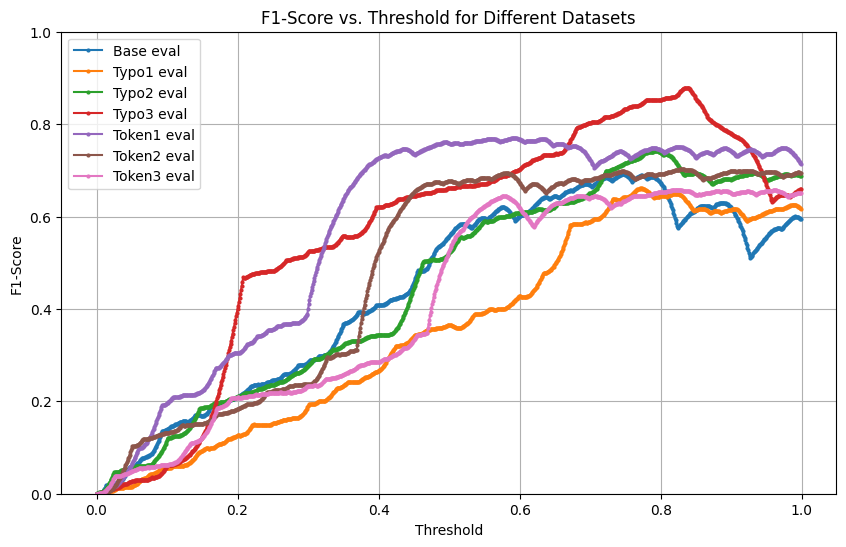

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from operator import itemgetter
import random



#def do_everything():






# Build variable for evaluation latter
def build_evaluation_list(prediction, confidence_threshold):
  model_result = []
  for p in prediction:
    if p > confidence_threshold:
      p = 1
    else:
      p = 0
    model_result.append(p)

  return model_result



# Run the model on one data set return it's prediction on the data
def model_run(model, evaluation_set, tokenizer):
  evalAdd1, evalAdd2, true_pred = create_addresses_pairs(evaluation_set)

  eval_addresses_pair = eval_addresses_pair = [(x1, x2) for x1, x2 in zip(evalAdd1, evalAdd2)]

  test_data_x1, test_data_x2 = create_test_data(tokenizer, eval_addresses_pair,  siamese_config['MAX_SEQUENCE_LENGTH'])

  preds = list(model.predict([test_data_x1, test_data_x2], verbose=1).ravel())

  results = [(x, y, z) for (x, y), z in zip(eval_addresses_pair, preds)]

  results.sort(key=itemgetter(2), reverse=True)

  return preds, true_pred




# Combine evaluation data sets
def combine_eval_data_sets(evalAdd, evalAddNegative, evalAddTypo1, evalAddTypo2, evalAddTypo3, evalAddToken1, evalAddToken2, evalAddToken3):
    base = evalAddNegative + evalAdd

    typo1 = evalAddNegative + evalAddTypo1

    typo2 = evalAddNegative + evalAddTypo2

    typo3 = evalAddNegative + evalAddTypo3

    token1 = evalAddNegative + evalAddToken1

    token2 = evalAddNegative + evalAddToken2

    token3 = evalAddNegative + evalAddToken3

    return base, typo1, typo2, typo3, token1, token2, token3











def plot_confusion_matrix(true_positives, true_negatives, false_positives, false_negatives):
    # Create the confusion matrix
    confusion_matrix = np.array([[true_negatives, false_positives],
                                 [false_negatives, true_positives]])

    # Set up the plot
    plt.imshow(confusion_matrix, cmap='Blues')
    plt.colorbar()

    # Add labels and ticks
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Add text annotations
    thresh = confusion_matrix.max() / 2
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center',
                     color='white' if confusion_matrix[i, j] > thresh else 'black')

    # Show the plot
    plt.show()




# Compute evaluation metrics and return them according to the model prediction
def compute_metrics(expected_result, normalized_model_result):
    true_positive = []
    false_positive = []
    true_negative = []
    false_negative = []

    for i in range(len(expected_result)):
        if expected_result[i] == 1 and normalized_model_result[i] == 1:
            true_positive.append(i)
        elif expected_result[i] == 0 and normalized_model_result[i] == 1:
            false_positive.append(i)
        elif expected_result[i] == 0 and normalized_model_result[i] == 0:
            true_negative.append(i)
        elif expected_result[i] == 1 and normalized_model_result[i] == 0:
            false_negative.append(i)

    # Precision
    if len(true_positive) + len(false_positive) > 0:
        precision = len(true_positive) / (len(true_positive) + len(false_positive))
    else:
        precision = 0.0

    # Recall = TP / TP + FN
    if len(true_positive) > 0:
        recall = len(true_positive) / (len(true_positive) + len(false_negative))
    else:
        recall = 0.0

    # F1 Score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0.0

    # Accuracy
    if len(expected_result) > 0:
        accuracy = (len(true_positive) + len(true_negative)) / len(expected_result)
    else:
        accuracy = 0.0

    return (
        precision,
        recall,
        accuracy,
        f1_score,
        true_positive,
        true_negative,
        false_positive,
        false_negative,
    )





def evaluate_with_thresholds(model_pred, true_pred, model_name, embedding_type, embedding_dim):
    thresholds = [i / 1000 for i in range(1001)]
    best_f1_score = 0.0
    best_threshold = 0.0
    best_accuracy = 0.0
    best_recall = 0.0
    best_precision = 0.0
    f1_scores = []

    for threshold in thresholds:
        model_pred_thresh = build_evaluation_list(model_pred, threshold)
        precision, recall, f1_score, accuracy, _, _, _, _ = compute_metrics(true_pred, model_pred_thresh)

        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_threshold = threshold
            best_accuracy = accuracy
            best_recall = recall
            best_precision = precision

        f1_scores.append(f1_score)

    # Print the evaluation results corresponding to the best F1-score (best threshold)
    print(f"Best threshold for {model_name} ({embedding_type} {embedding_dim}): {best_threshold}")
    print(f"Best F1 Score for {model_name} ({embedding_type} {embedding_dim}): {best_f1_score}")
    print(f"Accuracy corresponding to the best F1 Score: {best_accuracy}")
    print(f"Recall corresponding to the best F1 Score: {best_recall}")
    print(f"Precision corresponding to the best F1 Score: {best_precision}")

    evaluation_results = {
        "thresholds": thresholds,
        "precision": best_precision,
        "recall": best_recall,
        "accuracy": best_accuracy,
        "f1_scores": f1_scores,
        "best_threshold": best_threshold,
        "max_f1_score": best_f1_score
    }

    return evaluation_results



def printDetails(true_positive, true_negative, false_positive, false_negative, expected_label, predicted_label):

  for tp in true_positive:
    print("True positive record: " + " addresse1: " + str(evaladd1[tp[2]]) + " addresse2: " + str(evaladd2[tp[2]]) +
          " Expected label: " + str(expected_label[tp[2]]) +
          " Predicted label: " + str(predicted_label[tp[2]]))

  print("-----------------------------------------------------------------------------------------------")

  for tn in true_negative:
    print("True negative record: " + " addresse1: " + str(evaladd1[tn[2]]) + " addresse2: " + str(evaladd2[tn[2]]) +
          " Expected label: " + str(expected_label[tn[2]]) +
          " Predicted label: " + str(predicted_label[tn[2]]))

  print("-----------------------------------------------------------------------------------------------")

  for fp in false_positive:
    print("False positive record: " + " addresse1: " + str(evaladd1[fp[2]]) + " addresse2: " + str(evaladd2[fp[2]]) +
          " Expected label: " + str(expected_label[fp[2]]) +
          " Predicted label: " + str(predicted_label[fp[2]]))

  print("-----------------------------------------------------------------------------------------------")

  for fn in false_negative:
    print("False negative record: " + " addresse1: " + str(evaladd1[fn[2]]) + " addresse2: " + str(evaladd2[fn[2]]) +
          "Expected label: " + str(expected_label[fn[2]]) +
          "Predicted label: " + str(predicted_label[fn[2]]))





def plot_f1_scores(base_eval, typo1_eval, typo2_eval, typo3_eval, token1_eval, token2_eval, token3_eval):
    thresholds = base_eval["thresholds"]  # Use the thresholds from evaluation results

    plt.figure(figsize=(10, 6))

    marker_size = 2  # Adjust the marker size as needed

    plt.plot(thresholds, base_eval["f1_scores"], marker='o', markersize=marker_size, label='Base')
    plt.plot(thresholds, typo1_eval["f1_scores"], marker='o', markersize=marker_size, label='Typo1')
    plt.plot(thresholds, typo2_eval["f1_scores"], marker='o', markersize=marker_size, label='Typo2')
    plt.plot(thresholds, typo3_eval["f1_scores"], marker='o', markersize=marker_size, label='Typo3')
    plt.plot(thresholds, token1_eval["f1_scores"], marker='o', markersize=marker_size, label='Token1')
    plt.plot(thresholds, token2_eval["f1_scores"], marker='o', markersize=marker_size, label='Token2')
    plt.plot(thresholds, token3_eval["f1_scores"], marker='o', markersize=marker_size, label='Token3')

    plt.xlabel('Threshold')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs. Threshold for Different Datasets')
    plt.legend()
    plt.grid()
    plt.show()















# Sbert transformer


In [ ]:
!pip install -U sentence-transformers

In [ ]:
!pip install transformers

In [ ]:
for item in results:
    print(item[0], item[1], item[2])

78 zone industrielle In den Allern industrielle 78 zone In Allern den 0.99998426
3 Om Schachkrutchen Troine-Route 3 Om Schachkrutchen Troine Route 0.9990445
3 Om Schachkrutchen Troine-Route 3 Om Troine Route 0.9990445
Om 3 Schackrutchn Troine route 3 om Schackrtuche Troine-route 0.99899614
2 route de Filsborg, Altwies 2 route de Filsborg, Altwies 0.9987336
3 london street, Brooklyn 3 london street  Brooklyn 0.9795068
1 rue de la résistance, Ahn 1 rue de la résistance, Bascharagage 0.4277068
1  résistance Ahn 1  résistance Bascharagage 0.019620746
317 route de longwy Luxembourg 317 longwy Luxembourg 0.008418649
92A rue Adoplhe Fischer Luxembourg 92A Adoplhe Fissher Lux 0.00025853515
eflfo 2 ruddh  2 rue def rudh 0.00021753134
3 london street, Brooklyn 22 route de filsborg Atwiles 8.556247e-05
1 rue de la resistance, Ahn 1 rue de la résistance, Ahn 3.287196e-05
rue de ma résissrtance, ahn 103 ahn rue de la rsistance, 103 2.0682812e-05
22 routes de filsborg, Atwiles 23 route de filsborg, 

## Quickstart and embedding (using already trained model)

In [ ]:
# Quick install
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
sentence_embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")




Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.37173552e-02 -4.28515449e-02 -1.56286024e-02  1.40537303e-02
  3.95537727e-02  1.21796280e-01  2.94334106e-02 -3.17524187e-02
  3.54959629e-02 -7.93139935e-02  1.75878741e-02 -4.04369719e-02
  4.97259349e-02  2.54912246e-02 -7.18700588e-02  8.14968869e-02
  1.47069141e-03  4.79626991e-02 -4.50336412e-02 -9.92174670e-02
 -2.81769745e-02  6.45046085e-02  4.44670543e-02 -4.76217009e-02
 -3.52952331e-02  4.38671783e-02 -5.28566055e-02  4.33063833e-04
  1.01921506e-01  1.64072234e-02  3.26996595e-02 -3.45986746e-02
  1.21339476e-02  7.94870779e-02  4.58345609e-03  1.57777797e-02
 -9.68206208e-03  2.87625659e-02 -5.05805984e-02 -1.55793717e-02
 -2.87906546e-02 -9.62280575e-03  3.15556750e-02  2.27349028e-02
  8.71449187e-02 -3.85027491e-02 -8.84718448e-02 -8.75498448e-03
 -2.12343335e-02  2.08923239e-02 -9.02077407e-02 -5.25732562e-02
 -1.05638904e-02  2.88310610e-02 -1.61455162e-02  6.17837207e-03
 -1.23234

## text similarity using cosine distance (pre-trained model)


In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

# Two lists of sentences

sentencest1 = ['22 routes de filsborg, Atwiles',
              '2 route de Filsborg, Altwies',
              '50C rue du village, Abweiler',
              '1 rue de la résistance, Ahn',
              '1  résistance Ahn',
              '1 rue de la resistance, Ahn',
              '103 résistance, Ahn',
              '103 rue de la résistance, Ahn',
              'rue de ma résissrtance, ahn 103',
              "1 résistance Altwies",
              "317 route de longwy Luxembourg",
              "92A rue Adoplhe Fischer Luxembourg",
              "3 Om Schachkrutchen Troine-Route",
              "Om 3 Schackrutchn Troine route"
              "78 zone industrielle In den Allern",
              "3 london street, Brooklyn",
              "3 london street, Brooklyn",
              "eflfo 2 ruddh",
              '3 Om Schachkrutchen Troine-Route']

sentencest2 =  ['23 route de filsborg, Atwiles',
               '2 route de Filsborg, Altwies',
               '50C rue du villzge, Abxeiler ',
               '1 rue de la résistance, Bascharagage',
               '1  résistance Bascharagage',
               '1 rue de la résistance, Ahn',
               '1 filsborg, Auduin',
               '1 rue de filsborg, Auduin',
               'ahn rue de la rsistance, 103',
               "2 résistance Altwies",
               "317 longwy Luxembourg",
               "92A Adoplhe Fissher Lux",
               "3 Om Schachkrutchen Troine Route",
               "3 om Schackrtuche Troine-route",
               "industrielle 78 zone In Allern den",
               "22 route de filsborg Atwiles",
               "3 london street  Brooklyn",
               "2 rue def rudh",
               "3 Om Troine Route"]


#Compute embedding for both lists
embeddings1 = model.encode(sentencest1, convert_to_tensor=True)
embeddings2 = model.encode(sentencest2, convert_to_tensor=True)

#Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings1, embeddings2)

#Output the pairs with their score
for i in range(len(sentences1)):
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentencest1[i], sentencest2[i], cosine_scores[i][i]))

22 routes de filsborg, Atwiles 		 23 route de filsborg, Atwiles 		 Score: 0.9329
2 route de Filsborg, Altwies 		 2 route de Filsborg, Altwies 		 Score: 1.0000
50C rue du village, Abweiler 		 50C rue du villzge, Abxeiler  		 Score: 0.6411
1 rue de la résistance, Ahn 		 1 rue de la résistance, Bascharagage 		 Score: 0.8458
1  résistance Ahn 		 1  résistance Bascharagage 		 Score: 0.6088
1 rue de la resistance, Ahn 		 1 rue de la résistance, Ahn 		 Score: 1.0000
103 résistance, Ahn 		 1 filsborg, Auduin 		 Score: 0.1648
103 rue de la résistance, Ahn 		 1 rue de filsborg, Auduin 		 Score: 0.5644
rue de ma résissrtance, ahn 103 		 ahn rue de la rsistance, 103 		 Score: 0.7694
1 résistance Altwies 		 2 résistance Altwies 		 Score: 0.9541
317 route de longwy Luxembourg 		 317 longwy Luxembourg 		 Score: 0.8591
92A rue Adoplhe Fischer Luxembourg 		 92A Adoplhe Fissher Lux 		 Score: 0.5758
3 Om Schachkrutchen Troine-Route 		 3 Om Schachkrutchen Troine Route 		 Score: 0.9900
Om 3 Schackrutchn Tr

## Training embedding with our data

In [ ]:
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
import torch


# Define the model. Either from scratch or by loading a pre-trained model
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

# Define your train examples
train_examples = []
for i in range(len(sentences1)):
    train_examples.append(InputExample(texts=[sentences1[i], sentences2[i]], label=float(is_similar[i])))

# Define your train dataset, the dataloader, and the train loss
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=64)
train_loss = losses.CosineSimilarityLoss(model)

# Tune the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loss.to(device)
model.fit(train_objectives=[(train_dataloader, train_loss)],save_best_model=True, checkpoint_path = './' ,checkpoint_save_steps=100,  epochs=100, warmup_steps=100)


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/235 [00:00<?, ?it/s]

Iteration:   0%|          | 0/235 [00:00<?, ?it/s]